### Data preprocessing

In [1]:
# Importing necessary modules
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import the dataset
drugs = pd.read_excel("/Users/kevintomas/Desktop/nf-sep-20/Personality-and-Drug-use/drug_consumption.xls")

In [3]:
#Renaming Personality trait columns
drugs=drugs.rename(columns={"Escore":"Extraversion", "Nscore":"Neuroticism", "Oscore":"Openness", 
                      "Ascore":"Agreeableness","Cscore":"Conscientiousness", "Impulsive":"Impulsiveness",
                     "SS":"Sensation_Seeking"})

In [4]:
#Renaming drug columns
drugs=drugs.rename(columns={"Amphet":"Amphetamines", "Amyl":"Amyl_Nitrite", "Coke":"Cocaine", 
                      "Legalh":"Legal_Highs","Caff":"Caffein", "Choc":"Chocolate",
                     "Shrooms":"Mushrooms"})

In [5]:
#Handle the semer columns
drugs = drugs[drugs['Semer'] == "CL0"]
drugs = drugs.drop("Semer", axis=1)

In [6]:
#tranforming the drugs columns
drugs_columns = [
    'Alcohol',
    'Amphetamines',
    'Amyl_Nitrite',
    'Benzos',
    'Caffein',
    'Cannabis',
    'Chocolate',
    'Cocaine',
    'Crack',
    'Ecstasy',
    'Heroin',
    'Ketamine',
    'Legal_Highs',
    'LSD',
    'Meth',
    'Mushrooms',
    'Nicotine',
    'VSA'
]
# Changing staments concerning drug usage into integers
for i in drugs_columns:
    drugs[i] = drugs[i].apply(lambda x: int(x[-1]))

***An dieser Stelle könnte man yearly, monthly, weekly, daily user unterscheiden***

In [7]:
#splitting users from non-users
for i in drugs_columns:
    drugs[i] = drugs[i].apply(lambda x: 0 if x <3 else 1)

In [8]:
#dropping chocolate and caffein
drugs = drugs.drop("Chocolate", axis=1)
drugs = drugs.drop("Caffein", axis=1)

In [9]:
#splitting legal from illegal drugs
df_temp = drugs

df_temp = df_temp.drop("Alcohol", axis=1)

df_temp = df_temp.drop("Nicotine", axis=1)

#df_temp = df_temp.drop("legal_drugs", axis=1)

In [10]:
df_temp["illegal_drugs"] = df_temp.iloc[:, 13:].sum(axis=1)

In [11]:
df_temp["illegal_drugs"] = df_temp["illegal_drugs"].apply(lambda x: 0 if x<1 else 1)

In [12]:
drugs = pd.concat([df_temp["illegal_drugs"], drugs], axis=1)

In [13]:
drugs = drugs.drop("Alcohol", axis=1)

In [14]:
#converting the countries
country = ['USA' if c < -0.5 else 
           'New Zealand' if c > -0.5 and c < -0.4 else 
           'Other' if c > -0.4 and c < -0.2 else 
           'Australia' if c > -0.2 and c < 0 else 
           'Ireland' if c > 0 and c < 0.23 else 
           'Canada' if c > 0.23 and c < 0.9 else 
           'UK' 
           for c in drugs['Country']]

In [15]:
drugs['Country'] = country

In [16]:
#take only the data from the UK
drugs_uk = drugs.query("Country == 'UK'")

In [17]:
#converting the age column
warnings.filterwarnings('ignore')

age = ['18-24' if a <= -0.9 else 
       '25-34' if a >= -0.5 and a < 0 else 
       '35-44' if a > 0 and a < 1 else 
       '45-54' if a > 1 and a < 1.5 else 
       '55-64' if a > 1.5 and a < 2 else 
       '65+' 
       for a in drugs_uk['Age']]

drugs_uk["Age"] = age

In [18]:
#drop the 65+
drugs_uk = drugs_uk.query("Age != '65+'")

In [19]:
# women == 1 and men == 0
drugs_uk.Gender = drugs_uk.Gender.apply(lambda x: 1 if x > 0 else 0)

In [20]:
#drop columns we dont need
drugs_uk = drugs_uk.drop(["ID", "Age","Education", "Country", "Ethnicity"], axis=1)

In [22]:
drugs_uk = drugs_uk.iloc[:, :9]

In [23]:
drugs_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 0 to 1850
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   illegal_drugs      1032 non-null   int64  
 1   Gender             1032 non-null   int64  
 2   Neuroticism        1032 non-null   float64
 3   Extraversion       1032 non-null   float64
 4   Openness           1032 non-null   float64
 5   Agreeableness      1032 non-null   float64
 6   Conscientiousness  1032 non-null   float64
 7   Impulsiveness      1032 non-null   float64
 8   Sensation_Seeking  1032 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 80.6 KB


## Building the model

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import linear_model, svm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy import stats
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, make_scorer, fbeta_score, plot_confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score

***Generally:*** 
* Target value is ```illegal drugs```. If we would include all drugs, the target value would be highly inbalanced. The **balance** of the target is following: **61% (non-users) vs. 39 (user)**

* Only the **UK data** is used. The balance of the target value differs significantly from country to country, so a generalization from other countries to UK are diffcult
* ```ID```, ```Age``` and ```Education``` are dropped, because we are predicting the drug use for school students and therefore these columns would not make sense to be included
* ```Country``` can also be dropped due to the fact, that our scenario plays in the UK
* ```Ethnicity``` is also dropped
* All of the ```drug columns``` can be dropped, beacuse the target value is the subject of interest and the target arises from these columns
* So the **focus** of the model really lies on **the personaltiy traits** and less on the demografics


***Result:***
* Columns included: ```Gender```, ```Nscore```, ```Escore```, ```Oscore```, ```Ascore```, ```Cscore```, ```Impulsive```, ```SS``` and the **target** ```illegal_drugs```

### Splitting the data

In [25]:
y = np.array(drugs_uk.pop('illegal_drugs'))
X = drugs_uk.iloc[:, 0:]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=25)

## LogReg

In [27]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred_logreg = LogReg.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred_logreg ))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       123
           1       0.68      0.50      0.58        84

    accuracy                           0.70       207
   macro avg       0.69      0.67      0.67       207
weighted avg       0.70      0.70      0.69       207



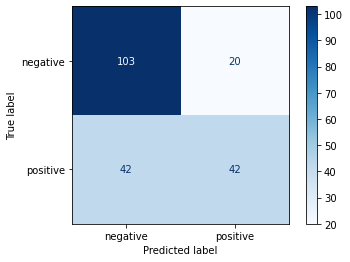

In [32]:
disp = plot_confusion_matrix(LogReg, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

### Changed the threshold to 0.4

In [33]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred_logreg  = LogReg.predict(X_test)

y_pred_tuned = (LogReg.predict_proba(X_test) >= 0.4)[:,1]

In [34]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       123
           1       0.60      0.69      0.64        84

    accuracy                           0.69       207
   macro avg       0.68      0.69      0.69       207
weighted avg       0.70      0.69      0.69       207



In [35]:
print(confusion_matrix(y_test, y_pred_tuned))

[[85 38]
 [26 58]]


In [36]:
logreg_recall = recall_score(y_test, y_pred_logreg )
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

In [37]:
coefficients = pd.Series(LogReg.coef_[0], X_train.columns)
coefficients

Gender              -0.500765
Neuroticism          0.152833
Extraversion        -0.133926
Openness             0.475577
Agreeableness       -0.103386
Conscientiousness   -0.392342
Impulsiveness        0.056900
Sensation_Seeking    0.742965
dtype: float64

## Decision Tree

In [38]:
# Creating the classifier object 
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            max_depth=7, min_samples_leaf=5) 

# Performing training 
clf_gini.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

In [39]:
y_pred_dt = clf_gini.predict(X_test) 

In [40]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       123
           1       0.63      0.52      0.57        84

    accuracy                           0.68       207
   macro avg       0.67      0.66      0.66       207
weighted avg       0.68      0.68      0.68       207



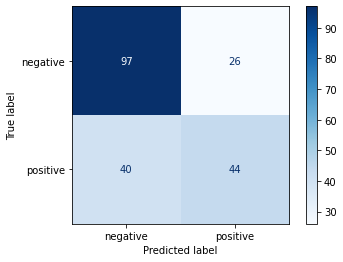

In [41]:
disp = plot_confusion_matrix(clf_gini, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

In [42]:
dt_recall = recall_score(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

***Change the threshold to 0.4***

In [43]:
y_pred_tuned = (clf_gini.predict_proba(X_test) >= 0.4)[:,1]
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       123
           1       0.61      0.60      0.60        84

    accuracy                           0.68       207
   macro avg       0.67      0.67      0.67       207
weighted avg       0.68      0.68      0.68       207



In [44]:
print(confusion_matrix(y_test, y_pred_tuned))

[[91 32]
 [34 50]]


In [45]:
features = ['Gender', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness',
       'Conscientiousness', 'Impulsiveness', 'Sensation_Seeking']

fi_model = pd.DataFrame({'feature': features,
                   'importance': clf_gini.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(8)

,feature,importance
7,Sensation_Seeking,0.362961
5,Conscientiousness,0.170502
3,Openness,0.097303
4,Agreeableness,0.082466
1,Neuroticism,0.081282
6,Impulsiveness,0.079994
2,Extraversion,0.073331
0,Gender,0.052161


## KNN

In [46]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean')

In [47]:
y_pred_knn = knn.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.72      0.80      0.75       123
           1       0.64      0.54      0.58        84

    accuracy                           0.69       207
   macro avg       0.68      0.67      0.67       207
weighted avg       0.69      0.69      0.69       207



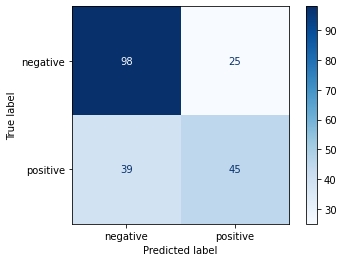

In [49]:
disp = plot_confusion_matrix(knn, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

In [50]:
knn_recall = recall_score(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

***Change the threshold to 0.4***

In [51]:
y_pred_tuned = (knn.predict_proba(X_test) >= 0.4)[:,1]
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       123
           1       0.54      0.73      0.62        84

    accuracy                           0.63       207
   macro avg       0.64      0.65      0.63       207
weighted avg       0.66      0.63      0.64       207



## SVM

In [52]:
svm_clf = svm.SVC(kernel='linear')

svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

In [53]:
svm_recall = recall_score(y_test, y_pred_svm)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

In [54]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       123
           1       0.68      0.51      0.59        84

    accuracy                           0.71       207
   macro avg       0.70      0.67      0.68       207
weighted avg       0.70      0.71      0.70       207



## Random Forest 

In [55]:
# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [56]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

In [57]:
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       123
           1       0.66      0.57      0.61        84

    accuracy                           0.71       207
   macro avg       0.69      0.68      0.69       207
weighted avg       0.70      0.71      0.70       207



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


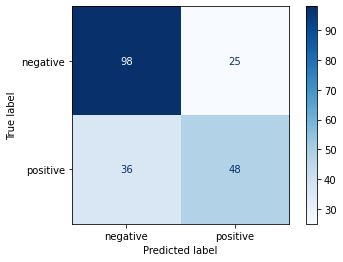

In [59]:
disp = plot_confusion_matrix(rf, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

In [60]:
rf_recall = recall_score(y_test, rf_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_accuracy

0.7053140096618358

In [61]:
features = ['Gender', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness',
       'Conscientiousness', 'Impulsiveness', 'Sensation_Seeking']

fi_model = pd.DataFrame({'feature': features,
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(8)

,feature,importance
7,Sensation_Seeking,0.167278
5,Conscientiousness,0.161155
3,Openness,0.157059
1,Neuroticism,0.135896
2,Extraversion,0.116549
4,Agreeableness,0.116500
6,Impulsiveness,0.112795
0,Gender,0.032768


***Change the threshold to 0.4***

In [62]:
y_pred_tuned = (rf.predict_proba(X_test) >= 0.4)[:,1]
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       123
           1       0.57      0.65      0.61        84

    accuracy                           0.66       207
   macro avg       0.65      0.66      0.65       207
weighted avg       0.67      0.66      0.66       207



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


***Hyperparameter Tuning***

In [63]:
'''# Hyperparameter grid
RSEED = 50

param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)'''

"# Hyperparameter grid\nRSEED = 50\n\nparam_grid = {\n    'n_estimators': np.linspace(10, 200).astype(int),\n    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),\n    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),\n    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),\n    'min_samples_split': [2, 5, 10],\n    'bootstrap': [True, False]\n}\n\n# Estimator for use in random search\nestimator = RandomForestClassifier(random_state = RSEED)\n\n# Create the random search model\nrs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, \n                        scoring = 'roc_auc', cv = 3, \n                        n_iter = 10, verbose = 5, random_state=RSEED)\n\n# Fit \nrs.fit(X_train, y_train)"

In [64]:
'''best_model_rf = rs.best_estimator_

best_model_rf.fit(X_train, y_train)
best_rf_predictions = best_model_rf.predict(X_test)
best_rf_probs = best_model_rf.predict_proba(X_test)[:, 1]'''

'best_model_rf = rs.best_estimator_\n\nbest_model_rf.fit(X_train, y_train)\nbest_rf_predictions = best_model_rf.predict(X_test)\nbest_rf_probs = best_model_rf.predict_proba(X_test)[:, 1]'

In [65]:
#print(classification_report(y_test, best_rf_predictions))

## XGBoost

In [66]:
xbg = XGBClassifier()
xbg.fit(X_train, y_train)

y_pred_xgb = xbg.predict(X_test)
predictions = [round(value) for value in y_pred_xgb]

In [67]:
print(classification_report(y_test, y_pred_xgb))
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       123
           1       0.65      0.58      0.62        84

    accuracy                           0.71       207
   macro avg       0.69      0.69      0.69       207
weighted avg       0.70      0.71      0.70       207



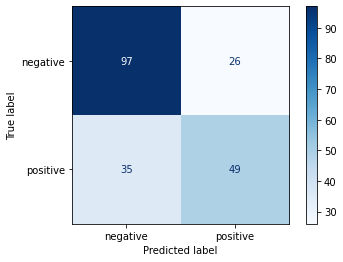

In [68]:
disp = plot_confusion_matrix(xbg, X_test, y_test,
                             display_labels=['negative', 'positive'],
                             cmap=plt.cm.Blues, 
                             normalize=None,
                             values_format = 'd')

plt.grid(False)
plt.show()

In [69]:
features = ['Gender', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness',
       'Conscientiousness', 'Impulsiveness', 'Sensation_Seeking']

fi_model = pd.DataFrame({'feature': features,
                   'importance': xbg.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(8)

,feature,importance
7,Sensation_Seeking,0.262024
0,Gender,0.133835
5,Conscientiousness,0.118004
6,Impulsiveness,0.110385
3,Openness,0.105046
1,Neuroticism,0.093156
2,Extraversion,0.089112
4,Agreeableness,0.088438


***Change the threshold to 0.4***

In [70]:
y_pred_tuned = (xbg.predict_proba(X_test) >= 0.4)[:,1]
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       123
           1       0.61      0.62      0.62        84

    accuracy                           0.69       207
   macro avg       0.67      0.68      0.68       207
weighted avg       0.69      0.69      0.69       207



***Hyperparameter Tuning***

In [71]:
'''model = XGBClassifier()
                                    
param_grid = {'n_estimators': stats.randint(100, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

kfold = KFold(n_splits=5, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(model, param_grid, scoring="accuracy", n_iter = 500, cv=kfold)
grid_result = grid_search.fit(X_train,y_train)'''

'model = XGBClassifier()\n                                    \nparam_grid = {\'n_estimators\': stats.randint(150, 1000),\n              \'learning_rate\': stats.uniform(0.01, 0.6),\n              \'subsample\': stats.uniform(0.3, 0.9),\n              \'max_depth\': [3, 4, 5, 6, 7, 8, 9],\n              \'colsample_bytree\': stats.uniform(0.5, 0.9),\n              \'min_child_weight\': [1, 2, 3, 4]\n             }\n\nkfold = KFold(n_splits=5, shuffle=True, random_state=10)\ngrid_search = RandomizedSearchCV(model, param_grid, scoring="accuracy", n_iter = 500, cv=kfold)\ngrid_result = grid_search.fit(X_train,y_train)'

In [98]:
model = XGBClassifier()

parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

kfold = KFold(n_splits=5, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(model, parameters, scoring="recall", n_iter = 500, cv=kfold)
grid_result = grid_search.fit(X_train,y_train)

In [99]:
best_model_xgb = grid_result.best_estimator_

In [100]:
best_model_xgb.fit(X_train, y_train)
best_xgb_predictions = best_model_xgb.predict(X_test)
best_xgb_probs = best_model_xgb.predict_proba(X_test)[:, 1]

In [101]:
print(classification_report(y_test, best_xgb_predictions))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       123
           1       0.66      0.62      0.64        84

    accuracy                           0.71       207
   macro avg       0.70      0.70      0.70       207
weighted avg       0.71      0.71      0.71       207



In [102]:
features = ['Gender', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness',
       'Conscientiousness', 'Impulsiveness', 'Sensation_Seeking']

fi_model = pd.DataFrame({'feature': features,
                   'importance': best_model_xgb.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(8)

,feature,importance
7,Sensation_Seeking,0.272763
3,Openness,0.124413
5,Conscientiousness,0.120372
0,Gender,0.117812
1,Neuroticism,0.098658
6,Impulsiveness,0.097756
2,Extraversion,0.084443
4,Agreeableness,0.083783


In [109]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

In [110]:
importances = best_model_xgb.feature_importances_

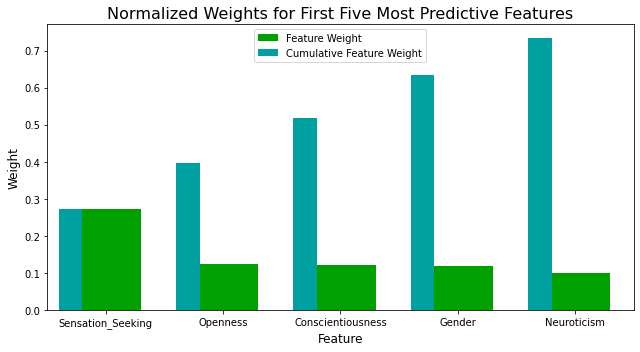

In [111]:
feature_plot(importances, X_train, y_train)

## Comparison of the models

In [85]:
print(f"LogReg Recall:\t{logreg_recall}")
print(f"LogReg Accuracy:\t{logreg_accuracy}")
print("----------------------------")
print(f"Decision Tree Recall:\t{dt_recall}")
print(f"Decision Tree Accuracy:\t{dt_accuracy}")
print("----------------------------")
print(f"SVM Recall:\t{svm_recall}")
print(f"SVM Accuracy:\t{svm_accuracy}")
print("----------------------------")
print(f"KNN Recall\t:{knn_recall}")
print(f"KNN Accuracy:\t{knn_accuracy}")
print("----------------------------")
print(f"SVM Recall:\t{svm_recall}")
print(f"SVM Accuracy:\t{svm_accuracy}")
print("----------------------------")
print(f"Random Forest Recall:\t{rf_recall}")
print(f"Random Forest Accuracy:\t{rf_accuracy}")
print("----------------------------")
print(f"XGB Recall:\t{xgb_recall}")
print(f"XGB Accuracy:\t{xgb_accuracy}")

LogReg Recall:	0.5
LogReg Accuracy:	0.7004830917874396
----------------------------
Decision Tree Recall:	0.5238095238095238
Decision Tree Accuracy:	0.6811594202898551
----------------------------
SVM Recall:	0.5119047619047619
SVM Accuracy:	0.7053140096618358
----------------------------
KNN Recall	:0.5357142857142857
KNN Accuracy:	0.6908212560386473
----------------------------
SVM Recall:	0.5119047619047619
SVM Accuracy:	0.7053140096618358
----------------------------
Random Forest Recall:	0.5714285714285714
Random Forest Accuracy:	0.7053140096618358
----------------------------
XGB Recall:	0.5833333333333334
XGB Accuracy:	0.7053140096618358
